# General Analysis Notebook
This notebook intents to tackle the problem of analyzing a whole batch. It mainly iterates over the many directories and process each one. Then makes a graph indicating the resulting value and the expected one. This is a neat way to understand how well is the analyzer performing generally.

## Update note
November 2018 - Modified by Gaston Snaider under the course "Taller de Programacion III" of the University of Buenos Aires.

## Requirements
This notebook requires that the root directory where reports are contains a ```description.yml``` file, indicating the various properties of the batch. Including the connection's top speed, the throttling configuration, the start time for each change and the time lapse for each throttling speed.
The network also ```requires a network_usage.log```, where the network usage speed per time is saved during the test.

## Input files
Here you should specify the input files and directories requiered for the test.

In [1]:
BATCHES_DIR = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/10-2rasps-2dic2018/logs-rasp3-2dic2018/batch-test-report'
TEST_CONFIG_FILE = '/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/10-2rasps-2dic2018/logs-rasp3-2dic2018/description.yml'
NET_USAGE_FILE='/home/gaston/workspace/taller-3/tix/CalibrationTestLogs/10-2rasps-2dic2018/logs-rasp3-2dic2018/network_usage.log'

## Imports and setup

In [2]:
NET_USAGE_SEPARATOR='|'

# Setup and import everything
%matplotlib notebook

import datetime
import math
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt

from processor import analysis, reports

from IPython.display import display

base_directory = BATCHES_DIR

## Test configuration
This is the configuration used during the test, as per the yaml file in TEST_CONFIG_FILE

In [3]:
with open(TEST_CONFIG_FILE) as fp:
    test_config = yaml.load(fp)
test_config

{'intervals': [{'duration_minutes': 60, 'speed_percentage': 0},
  {'duration_minutes': 60, 'speed_percentage': 25},
  {'duration_minutes': 60, 'speed_percentage': 50},
  {'duration_minutes': 60, 'speed_percentage': 75},
  {'duration_minutes': 60, 'speed_percentage': 100},
  {'duration_minutes': 60, 'speed_percentage': 0}],
 'max_speed_kbps': 24000,
 'network_interface': 'wlan0',
 'start_time': 1543730400.135639}

## Measued and expected network usage
Here we calculate the network usage as measured by the TiX system, and the expected network usage based on the test configuration.

In [4]:
def get_analyzer_results(reports_batch_dir):
    rh = reports.ReportHandler(os.path.join(base_directory, reports_batch_dir))
    ip, obs_set = rh.get_ip_and_processable_observations()
    if ip is None and obs_set is None:
        raise ValueError('Reports batch directory {} has no reports to use!'.format(reports_batch_dir))
    analyzer = analysis.Analyzer(obs_set)
    results = analyzer.get_results()
    return results

def get_expected_usage(batch_start_time, batch_end_time):
    batch_starting_conf, batch_ending_conf = None, None
    
    test_start_epoch = test_config['start_time']
    experiment_start_epoch = test_start_epoch
    for experiment_configuration in test_config['intervals']:
        experiment_lapse = experiment_configuration['duration_minutes'] * 60
        experiment_start = experiment_start_epoch
        experiment_end = experiment_start_epoch + experiment_lapse
        
        if experiment_start <= batch_start_time < experiment_end:
            batch_starting_conf = experiment_configuration
            batch_starting_conf_start_epoch = experiment_start
        if experiment_start <= batch_end_time < experiment_end:
            batch_ending_conf = experiment_configuration
            batch_ending_conf_start_epoch = experiment_start
        if batch_starting_conf is not None and batch_ending_conf is not None:
            break
        
        # Increment the start epoch for the next experiment.
        experiment_start_epoch = experiment_end
        
    if batch_starting_conf is None and batch_ending_conf is None:
        return None
#         raise ValueError('Batch for start time: {} and end time {} has no config.'.format(batch_start_time,
#                                                                                           batch_end_time))
    if batch_ending_conf is None:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    elif batch_starting_conf is None:
        expected_usage = batch_ending_conf['speed_percentage'] / 100
    elif batch_starting_conf['speed_percentage'] / 100 == batch_ending_conf['speed_percentage'] / 100:
        expected_usage = batch_starting_conf['speed_percentage'] / 100
    else:
        batch_lapse = batch_end_time - batch_start_time
        batch_starting_conf_lapse = batch_starting_conf_start_epoch + batch_starting_conf['duration_minutes']*60 - batch_start_time
        batch_ending_conf_lapse = batch_end_time - batch_ending_conf_start_epoch
        expected_usage = ((batch_starting_conf_lapse / batch_lapse) * batch_starting_conf['speed_percentage'] / 100 +
            (batch_ending_conf_lapse / batch_lapse) * batch_ending_conf['speed_percentage'] / 100)
    return expected_usage
    

In [5]:
columns = ['batch_start_timestamp', 'batch_end_timestamp',
           'batch_start_time', 'batch_end_time',
           'downstream_hurst_rs', 'downstream_hurst_wavelet',
           'downstream_quality', 'downstream_usage',
           'upstream_hurst_rs', 'upstream_hurst_wavelet',
           'upstream_quality', 'upstream_usage',
           'expected_downstream_usage', 'error', 'relative_error']
data = pd.DataFrame(columns=columns)

for reports_batch_dir in sorted(os.listdir(base_directory)):
    reports_batch_dir_path = os.path.join(base_directory, reports_batch_dir)
    if not os.path.isdir(reports_batch_dir_path): continue
    results = get_analyzer_results(reports_batch_dir_path)
    batch_start_time = int(reports_batch_dir)
    batch_end_time = results['timestamp']
    expected_usage = get_expected_usage(batch_start_time, batch_end_time)
    if expected_usage is None: continue
    df_ = pd.DataFrame([(batch_start_time, batch_end_time, 
                         datetime.datetime.fromtimestamp(batch_start_time),
                         datetime.datetime.fromtimestamp(batch_end_time),
                         results['downstream']['hurst']['rs'], results['downstream']['hurst']['wavelet'],
                         results['downstream']['quality'], results['downstream']['usage'], 
                         results['upstream']['hurst']['rs'], results['upstream']['hurst']['wavelet'],
                         results['upstream']['quality'], results['upstream']['usage'],
                         expected_usage, 
                         math.fabs(expected_usage - results['downstream']['usage']), 
                         (math.fabs(expected_usage - results['downstream']['usage']) / expected_usage) 
                         if expected_usage != 0 else math.fabs(expected_usage - results['downstream']['usage']))
                       ], 
                       columns=columns)
    data = data.append(df_)
data = data.sort_values(by=['batch_start_time']).reset_index(drop=True)
display(data)

/home/gaston/workspace/taller-3/tix/forks/tix-time-processor-fork/processor/hurst.py:300: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fit, coef1 = numpy.linalg.lstsq(A, log10_y)[0]
/home/gaston/workspace/taller-3/tix/forks/tix-time-processor-fork/processor/hurst.py:303: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  fitH, coef2 = numpy.linalg.lstsq(B, log10_yx)[0]
/home/gaston/workspace/taller-3/tix/forks/tix-time-processor-fork/processor/hurst.py:197: FutureWarning: `rcond` parameter will change to the default of mac

,batch_start_timestamp,batch_end_timestamp,batch_start_time,batch_end_time,downstream_hurst_rs,downstream_hurst_wavelet,downstream_quality,downstream_usage,upstream_hurst_rs,upstream_hurst_wavelet,upstream_quality,upstream_usage,expected_downstream_usage,error,relative_error
0,1543730471,1543731262,2018-12-02 03:01:11,2018-12-02 03:14:22,0.551146,0.557341,1.0,0.136264,0.487940,0.391146,1.0,0.646739,0.000000,0.136264,0.136264
1,1543731020,1543732147,2018-12-02 03:10:20,2018-12-02 03:29:07,0.624391,0.590162,1.0,0.088660,0.523714,0.421788,1.0,0.240786,0.000000,0.088660,0.088660
2,1543731569,1543732530,2018-12-02 03:19:29,2018-12-02 03:35:30,0.533585,0.401910,1.0,0.110092,0.589014,0.306437,1.0,0.609467,0.000000,0.110092,0.110092
3,1543732118,1543733064,2018-12-02 03:28:38,2018-12-02 03:44:24,0.574323,1.002819,0.0,0.057471,0.506933,0.431080,1.0,0.667327,0.000000,0.057471,0.057471
4,1543732667,1543733672,2018-12-02 03:37:47,2018-12-02 03:54:32,0.565663,0.544716,1.0,0.063107,0.579907,0.508046,1.0,0.687050,0.000000,0.063107,0.063107
5,1543733216,1543734413,2018-12-02 03:46:56,2018-12-02 04:06:53,0.455535,-0.061149,1.0,0.209169,0.524698,0.263766,1.0,0.382184,0.086229,0.122940,1.425740
6,1543733765,1543734454,2018-12-02 03:56:05,2018-12-02 04:07:34,0.521537,0.479705,1.0,0.365145,0.525889,0.584307,1.0,0.546117,0.164682,0.200463,1.217271
7,1543734375,1543735190,2018-12-02 04:06:15,2018-12-02 04:19:50,0.494467,0.228198,1.0,0.274939,0.518499,0.266160,1.0,0.484108,0.250000,0.024939,0.099757
8,1543734925,1543735872,2018-12-02 04:15:25,2018-12-02 04:31:12,0.540478,0.849398,1.0,0.446341,0.552219,0.218683,1.0,0.549884,0.250000,0.196341,0.785366
9,1543735479,1543736106,2018-12-02 04:24:39,2018-12-02 04:35:06,0.542250,0.683902,1.0,0.258824,0.513497,0.523216,1.0,0.474654,0.250000,0.008824,0.035294


## Actual network usage
Here we process the data from NET_USAGE_FILE, which corresponds to the network usage measured in the specified network_interface during the test

In [6]:
NET_USAGE_SAMPLES_PER_BATCH = 9

net_usage_time = []
net_usage_speed = []
grouped_net_usage_time = []
grouped_net_usage_speed = []

net_usage_per_batch_time = []
net_usage_per_batch_speed = []


with open(NET_USAGE_FILE) as net_usage_file:
  # Skip header
  next(net_usage_file)
  
#   TODO Remove this after system-test is updated
  # Skip first row which corresponds to first minute
  next(net_usage_file)
  
  for line in net_usage_file:
    (epoch, speed) = line.split(NET_USAGE_SEPARATOR)
    usage_timestamp =  float(epoch)
    
    # TODO switch these two lines after testing, or after we get a test sample with the division done by the test.
    # speed_kbps = int(speed)
    speed_kbps = int(speed) / (1000.0 * 60.0)
    
    net_usage_per_batch_time.append(usage_timestamp)
    
    # TODO Remove this after the issue of negatives values is fixed on the client side
    if speed_kbps < 0:
      net_usage_per_batch_speed.append(net_usage_speed[-1])
    else:
      net_usage_per_batch_speed.append(speed_kbps)
    
    if (len(net_usage_per_batch_speed) == NET_USAGE_SAMPLES_PER_BATCH):
      net_usage_time.extend(net_usage_per_batch_time)
      net_usage_speed.extend(net_usage_per_batch_speed)
      
      grouped_net_usage_time.append(net_usage_per_batch_time[0])
      grouped_net_usage_speed.append(sum(net_usage_per_batch_speed) / len(net_usage_per_batch_speed))
      
      net_usage_per_batch_time = []
      net_usage_per_batch_speed = []

net_usage_time = [datetime.datetime.fromtimestamp(timestamp) for timestamp in net_usage_time]
grouped_net_usage_time = [datetime.datetime.fromtimestamp(timestamp) for timestamp in grouped_net_usage_time]


## Test results

<IPython.core.display.Javascript object>


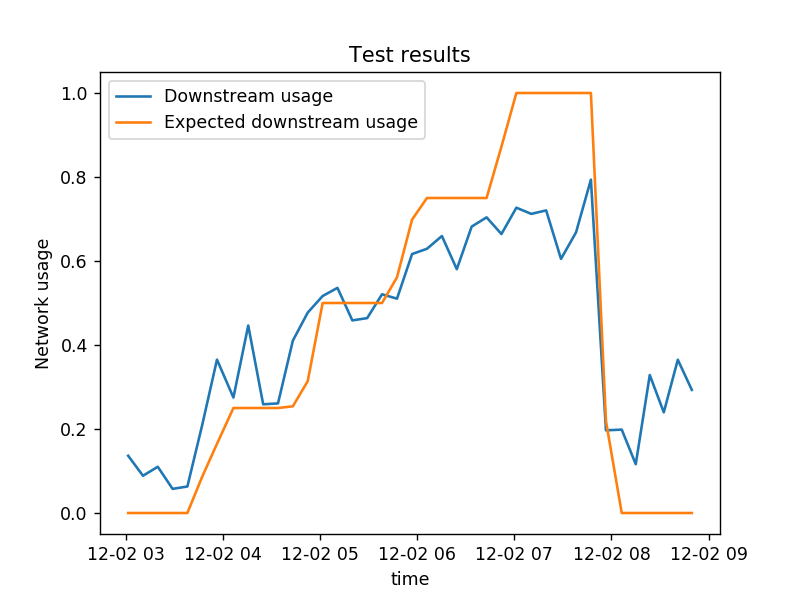

In [7]:
plt.figure()
plt.plot(data['batch_start_time'], data['downstream_usage'])
plt.plot(data['batch_start_time'], data['expected_downstream_usage'])
plt.xlabel('time')
plt.ylabel('Network usage')
plt.title('Test results')
plt.legend(['Downstream usage', 'Expected downstream usage'])
plt.show()

<IPython.core.display.Javascript object>


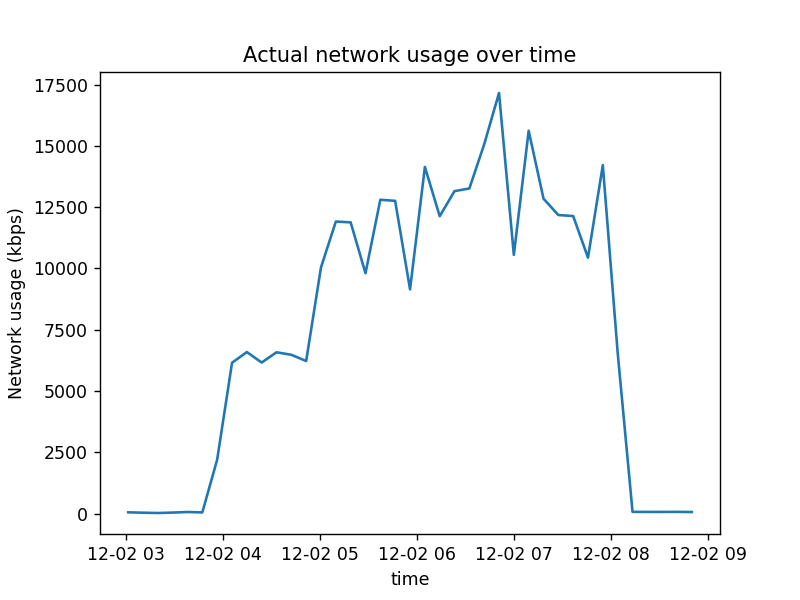

In [8]:
plt.figure()
plt.plot(grouped_net_usage_time,grouped_net_usage_speed)
plt.xlabel('time')
plt.ylabel('Network usage (kbps)')
plt.title('Actual network usage over time')
plt.show()

<IPython.core.display.Javascript object>


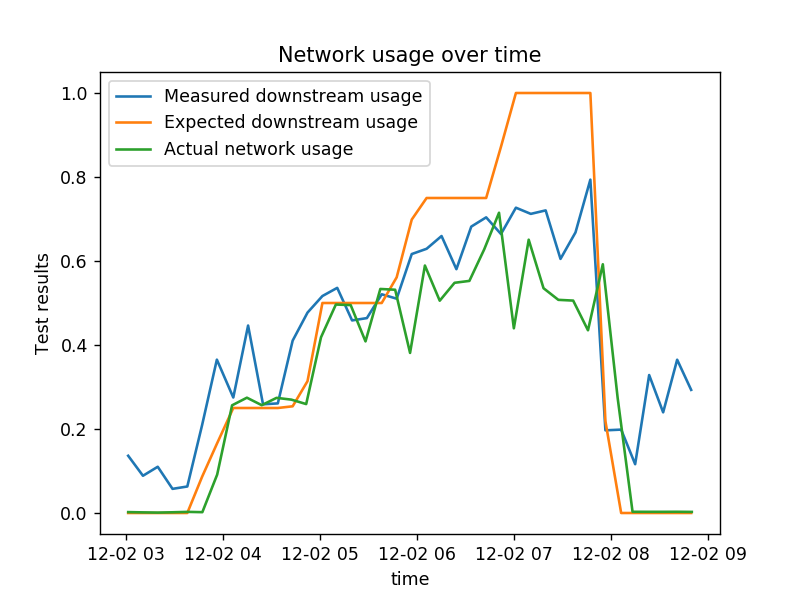

In [9]:
normalized_net_usage = [speed_kbps / test_config['max_speed_kbps'] for speed_kbps in grouped_net_usage_speed]
plt.figure()
plt.plot(data['batch_start_time'], data['downstream_usage'])
plt.plot(data['batch_start_time'], data['expected_downstream_usage'])
plt.plot(grouped_net_usage_time, normalized_net_usage)
plt.xlabel('time')
plt.ylabel('Test results')
plt.title('Network usage over time')
plt.legend(['Measured downstream usage', 'Expected downstream usage', 'Actual network usage'])
plt.show()

## Error between expected network usage and measured network usage 

In [10]:
display(data[['error', 'relative_error']].describe(include='all'))

,error,relative_error
count,39.000000,39.000000
mean,0.145204,0.256959
std,0.110899,0.301685
min,0.008824,0.033195
25%,0.048442,0.085805
50%,0.120902,0.136264
75%,0.207112,0.290472
max,0.395010,1.425740


<IPython.core.display.Javascript object>


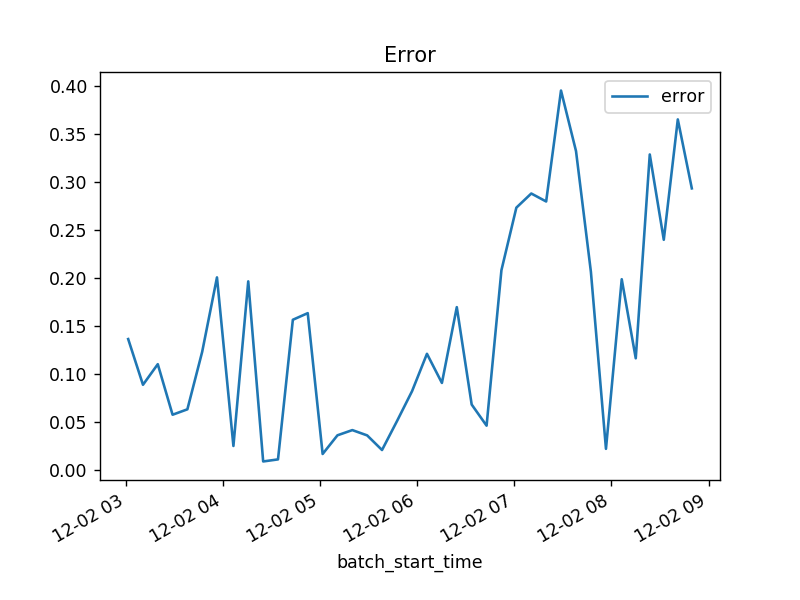

In [11]:
data.plot(x='batch_start_time', y='error', kind='line', title='Error')

<IPython.core.display.Javascript object>


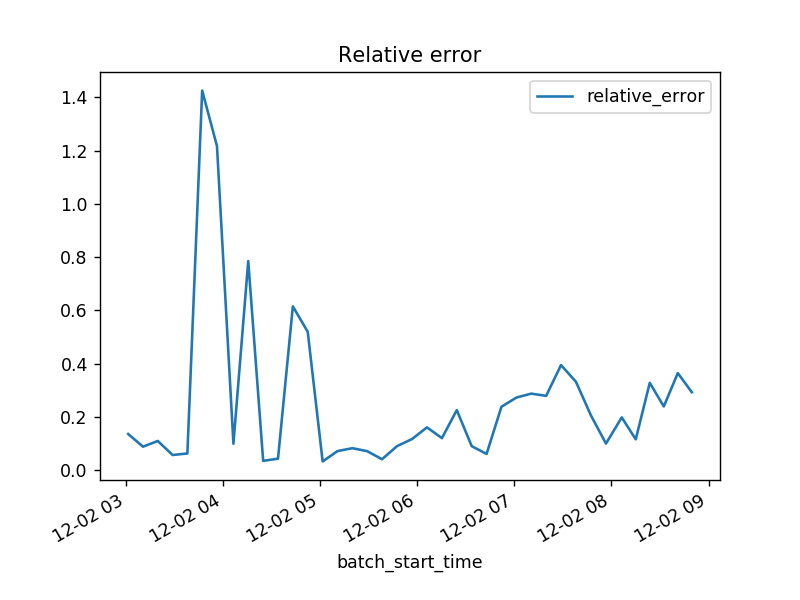

In [12]:
data.plot(x='batch_start_time', y='relative_error', kind='line', title='Relative error')

## Error between expected network usage and actual network usage

In [13]:
error_times = []
errors = []
relative_errors = []
for time, measured_usage, actual_usage in zip(data['batch_start_time'], data['downstream_usage'], normalized_net_usage):
  error_times.append(time)
  errors.append(math.fabs(actual_usage - measured_usage))
  relative_errors.append((math.fabs(actual_usage - measured_usage) / actual_usage) 
                          if actual_usage != 0 else math.fabs(actual_usage - measured_usage))


<IPython.core.display.Javascript object>


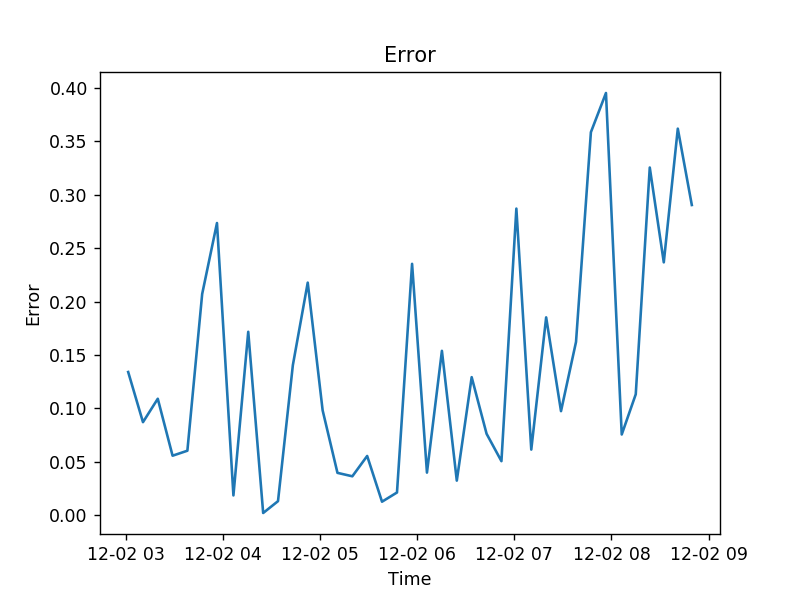

In [14]:
plt.figure()
plt.plot(error_times, errors)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Error')
plt.show()

<IPython.core.display.Javascript object>


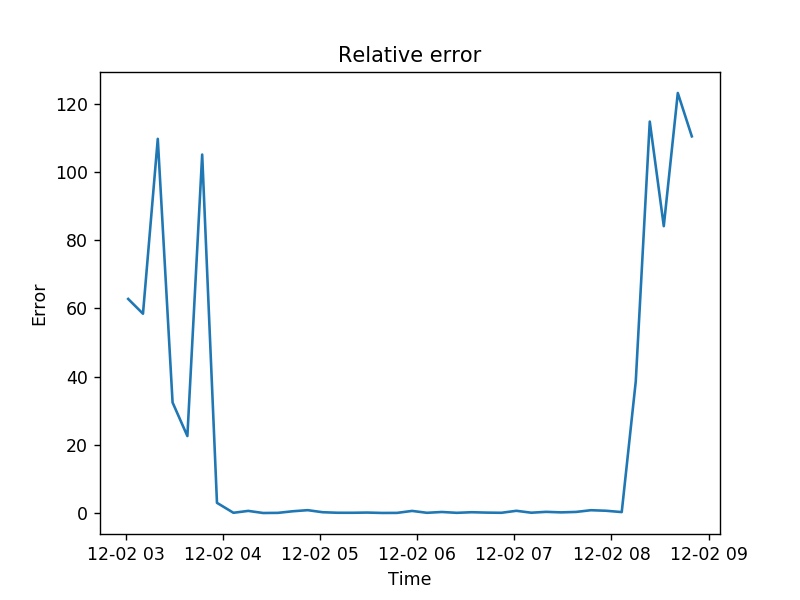

In [15]:
plt.figure()
plt.plot(error_times, relative_errors)
plt.xlabel('Time')
plt.ylabel('Error')
plt.title('Relative error')
plt.show()

In [16]:
# TODO remove after testing
# This is to measure the time diff between the generated batches from TiX and from the network_usage log
from datetime import timezone

for actual_net_time, measured_net_time in zip(grouped_net_usage_time, data['batch_start_time']):
  actual_timestamp = actual_net_time.replace(tzinfo=timezone.utc).timestamp()
  measured_timestamp = measured_net_time.timestamp()
  print('Diff {} sec'.format(actual_timestamp - measured_timestamp))
  print()

Diff 1.4781699180603027 sec

Diff 3.0022270679473877 sec

Diff 4.720094919204712 sec

Diff 6.382627010345459 sec

Diff 8.05122709274292 sec

Diff 9.674901962280273 sec

Diff 11.395695924758911 sec

Diff -44.997297048568726 sec

Diff -44.42405390739441 sec

Diff -48.084213972091675 sec

Diff -47.50552701950073 sec

Diff -47.87860608100891 sec

Diff -49.41432595252991 sec

Diff -51.93466401100159 sec

Diff -50.4030020236969 sec

Diff -51.8396680355072 sec

Diff -51.33630394935608 sec

Diff -51.642914056777954 sec

Diff -56.071712017059326 sec

Diff -62.47435188293457 sec

Diff -62.98144507408142 sec

Diff -67.43451499938965 sec

Diff -68.93455600738525 sec

Diff -70.43101906776428 sec

Diff -72.89254093170166 sec

Diff -73.22107291221619 sec

Diff -76.60779809951782 sec

Diff -78.08179903030396 sec

Diff -79.47707796096802 sec

Diff -79.69446206092834 sec

Diff -86.02653694152832 sec

Diff -87.639564037323 sec

Diff -96.04648900032043 sec

Diff -130.4752058982849 sec

Diff -97.0265789031